In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import cv2
import os

# Check Data Accessment

In [3]:
path='/content/drive/My Drive/Colab Notebooks/Data/flowers/flowers/'

img_names = []
for folder,_,filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
print("images len:",len(img_names))


images len: 4326


# Data Augmentation



In [4]:
transform = {
    "train": transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.485,0.456,0.406], std = [0.229,0.224,0.225])
    ]),
    "Test": transforms.Compose({
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.485,0.456,0.406], std = [0.229,0.224,0.225])
    })
}

In [5]:
root='/content/drive/My Drive/Colab Notebooks/Data/flowers/'

full_dataset = datasets.ImageFolder(os.path.join(root,'flowers'),transform=transform["train"])
print('full dataset:',full_dataset)

full dataset: Dataset ImageFolder
    Number of datapoints: 4323
    Root location: /content/drive/My Drive/Colab Notebooks/Data/flowers/flowers
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.5, 1.5], contrast=None, saturation=None, hue=None)
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


# Split train set and test set

In [6]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

print('train size:',train_size)
print('test size:',test_size)
train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train size: 3458
test size: 865


In [7]:
train_btch_size =32
test_btch_size = 16

train_loader = DataLoader(train_data,batch_size=train_btch_size, shuffle = True,num_workers = 8)
test_loader =  DataLoader(test_data,batch_size =test_btch_size ,shuffle = False,num_workers = 8)

class_names = full_dataset.classes
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


# CNN

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,1)
        self.conv2 = nn.Conv2d(32,64,3,1)
        self.conv3 = nn.Conv2d(64,128,3,1)
        self.fc1   = nn.Linear(128*26*26,16)
        self.fc2   = nn.Linear(16,8)
        self.fc3   = nn.Linear(8,5)
        
    def forward(self,X):
        X = nn.Dropout(p=0.5)
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = nn.Dropout(p=0.5)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2)
        
        X = X.view(-1,128*26*26)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim =1)

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.drop_out = nn.Dropout(p=0.5)
        self.fc1   = nn.Linear(128*26*26,1024)
        self.fc2   = nn.Linear(1024,5)
        
    def forward(self,X):
        X = self.layer1(X)
        X = self.layer2(X)
        X = self.layer3(X)
        X = X.view(-1,128*26*26)
        X = self.drop_out(X)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X,dim =1)

# Check GPU

In [9]:
# We are going to use pytorch GPU therefore we need to convert datatypes into .cuda() format
from torch.autograd import Variable

use_gpu = torch.cuda.is_available()
if use_gpu:
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  print("GPU not avaliable")

1
Tesla K80


> scheduler stands for learning rate decay.


In [14]:
CNN_model=ConvNet()
if use_gpu:
    CNN_model.cuda() 
criterion= nn.CrossEntropyLoss()
if use_gpu:
     criterion = criterion.cuda()
optimizer = torch.optim.Adam(CNN_model.parameters(),lr=0.001,weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
CNN_model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=86528, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=5, bias=True)
)

# Train and Test

`trn_corr+=(predicted == y_train).sum()`:<br>
`predicted` and `y_train` are matrixs of the same size (normally (1,20)).<br>
`np.sum()` will calculate the total number of result that satisfy the condition. 
[source](https://note.nkmk.me/en/python-numpy-count/).

In [15]:
%%time
epochs = 30
train_losses =[]
test_losses = []
train_correct =[]
test_correct=[]
for epoch in range(epochs):
    
    trn_corr =0
    tst_corr =0

    for batch,(X_train,y_train) in enumerate(train_loader):
        batch+=1
        if torch.cuda.is_available():
            X_train = Variable(X_train).cuda()
            y_train = Variable(y_train).cuda()
        
        y_pred = CNN_model(X_train)
        loss   = criterion(y_pred,y_train)
        predicted =torch.max(y_pred.data,1)[1]
        trn_corr+=(predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch%100 ==0:
            print(f'epoch:{epoch} batch:{batch} loss:{loss.item()} accuracy:{trn_corr.item()*100/(batch*train_btch_size)}')
            
    scheduler.step()    
    train_losses.append(loss)
    train_correct.append(trn_corr.item()*100/(batch*train_btch_size))
    

    with torch.no_grad():
        for batch,(X_test,y_test) in enumerate(test_loader):
            if torch.cuda.is_available():
                X_test = Variable(X_test).cuda()
                y_test = Variable(y_test).cuda()

            y_val= CNN_model(X_test)
            predicted_test = torch.max(y_val.data,1)[1]
            tst_corr +=(predicted_test==y_test).sum()

        loss =criterion(y_val,y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr.item()*100/(batch*test_btch_size))  
    

epoch:0 batch:100 loss:1.3142238855361938 accuracy:40.71875
epoch:1 batch:100 loss:1.4365990161895752 accuracy:51.25
epoch:2 batch:100 loss:0.8763147592544556 accuracy:56.28125
epoch:3 batch:100 loss:1.1195529699325562 accuracy:60.71875
epoch:4 batch:100 loss:1.330574870109558 accuracy:61.5
epoch:5 batch:100 loss:0.8416556715965271 accuracy:65.96875
epoch:6 batch:100 loss:0.8899966478347778 accuracy:68.28125
epoch:7 batch:100 loss:0.9905222654342651 accuracy:68.875
epoch:8 batch:100 loss:0.8469021916389465 accuracy:70.90625
epoch:9 batch:100 loss:0.6940653324127197 accuracy:71.15625
epoch:10 batch:100 loss:0.6448538899421692 accuracy:72.40625
epoch:11 batch:100 loss:0.8572308421134949 accuracy:74.0625
epoch:12 batch:100 loss:0.6252860426902771 accuracy:75.625
epoch:13 batch:100 loss:0.5772308707237244 accuracy:75.71875
epoch:14 batch:100 loss:0.5441975593566895 accuracy:77.09375
epoch:15 batch:100 loss:0.7007846236228943 accuracy:77.9375
epoch:16 batch:100 loss:0.6226754188537598 accur

# Visualize Result

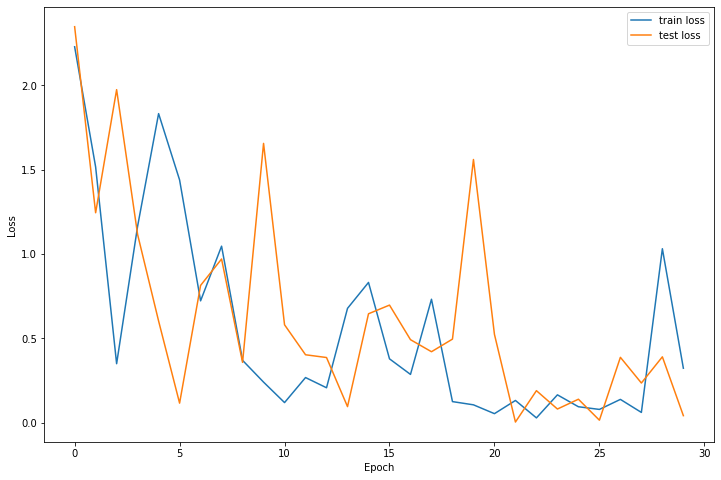

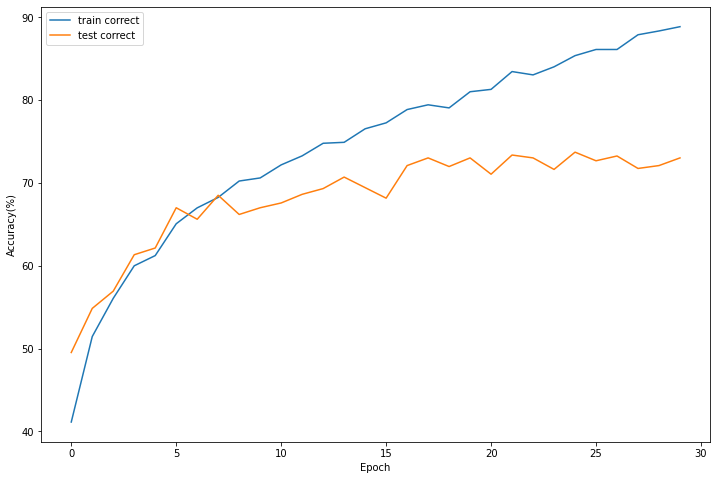

In [16]:
#  Plot train loss and test loss 
plt.figure(figsize=(12,8))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses,label = 'train loss')
plt.plot(test_losses,label  = 'test loss')
plt.legend()

#  Plot train and test accuracy
plt.figure(figsize=(12,8))
plt.xlabel("Epoch")
plt.ylabel("Accuracy(%)")
plt.plot(train_correct,label = 'train correct')
plt.plot(test_correct, label = 'test correct')
plt.legend()

## Use TensorBoard to visualize